# Recommend candidates building via keras
[recommend keras](https://nipunbatra.github.io/blog/2017/recommend-keras.html)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
ratings = pd.read_csv("../input/ml-1m/ratings.dat", sep='::', names="user_id,item_id,rating,timestamp".split(","))

In [3]:
ratings.head()

,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


So, each record (row) shows the rating for a user, item (movie) pair.

In [4]:
ratings.shape

(1000209, 4)

In [5]:
len(ratings.user_id.unique()), len(ratings.item_id.unique())

(6040, 3706)

In [6]:
ratings.user_id = ratings.user_id.astype('category').cat.codes.values
ratings.item_id = ratings.item_id.astype('category').cat.codes.values

In [7]:
ratings.head()

,user_id,item_id,rating,timestamp
0,0,1104,5,978300760
1,0,639,3,978302109
2,0,853,3,978301968
3,0,3177,4,978300275
4,0,2162,5,978824291


Train test split
We'll now split our dataset of 1M ratings into train (containing 800k ratings) and test (containing 200k ratings). Given the train set, we'd like to accurately estimate the ratings in the test set.

In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(ratings, test_size=0.3)
train, valid = train_test_split(train, test_size=0.3)

In [9]:
print(train.shape, valid.shape, test.shape)

(490102, 4) (210044, 4) (300063, 4)


## Matrix factorisation

One popular recommender systems approach is called **Matrix Factorisation**. It works on the principle that we can learn a low-dimensional representation (embedding) of user and movie. For example, for each movie, we can have how much action it has, how long it is, and so on. For each user, we can encode how much they like action, or how much they like long movies, etc. Thus, we can combine the user and the movie embeddings to estimate the ratings on unseen movies. This approach can also be viewed as: given a matrix (A [M X N]) containing users and movies, we want to estimate low dimensional matrices (W [M X k] and H [M X k]), such that: A≈W.HT

## Matrix factorisation in Keras
We'll now write some code to solve the recommendation problem by matrix factorisation in Keras. We're trying to learn two low-dimensional embeddings of users and items.

In [10]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
n_users, n_movies = len(ratings.user_id.unique()), len(ratings.item_id.unique())
n_latent_factors = 3

Using TensorFlow backend.


The key thing is to learn an embedding for movies and users, and then combine them using the dot product! For estimating the rating, for each user, movie pair of interest, we'd take the dot product of the respective user and item embedding. As an example, if we have 2 dimensions in our user and item embedding, which say correspond to [how much user likes action, how much user likes long movies], and the item embedding is [how much action is in the movie, how long is the movie]. Then, we can predict for a user `u`, and movie `m` as how much `u` likes action × how much action is there in `m` + how much `u` likes long movies × how long is `m`.

Our model would optimise the emebedding such that we minimise the mean squared error on the ratings from the train set.

In [11]:
movie_input = keras.layers.Input(shape=[1],name='ItemId')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='Item-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenItems')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='UserId')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors,name='User-Embedding')(user_input))

prod = keras.layers.merge.dot([movie_vec, user_vec], axes=1, name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

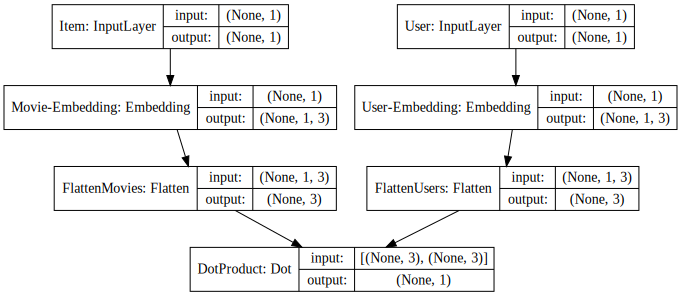

In [12]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

We can see that in the `Merge` layer, we take the dot product of the user and the item embeddings to obtain the rating.

We can also summarise our model as follows:

In [13]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         11121       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         18123       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

So, we have `29,244` parameters to learn! Let's train our model now!

In [14]:
callbacks = [keras.callbacks.EarlyStopping(patience=5, verbose=1)]
svd_history = model.fit(x=[train.user_id, train.item_id], 
                        y=train.rating, 
                        batch_size=128,
                        validation_data=([valid.user_id, valid.item_id], valid.rating),
                        epochs=100, 
                        verbose=1)

Train on 490102 samples, validate on 210044 samples
Epoch 1/100
490102/490102 [==============================] - 5s 9us/step - loss: 10.4027 - val_loss: 4.3412
Epoch 2/100
490102/490102 [==============================] - 4s 8us/step - loss: 2.4825 - val_loss: 1.5954
Epoch 3/100
490102/490102 [==============================] - 4s 8us/step - loss: 1.2595 - val_loss: 1.0935
Epoch 4/100
490102/490102 [==============================] - 4s 8us/step - loss: 0.9809 - val_loss: 0.9458
Epoch 5/100
490102/490102 [==============================] - 4s 8us/step - loss: 0.8926 - val_loss: 0.8937
Epoch 6/100
490102/490102 [==============================] - 4s 9us/step - loss: 0.8601 - val_loss: 0.8726
Epoch 7/100
490102/490102 [==============================] - 5s 10us/step - loss: 0.8464 - val_loss: 0.8639
Epoch 8/100
490102/490102 [==============================] - 4s 8us/step - loss: 0.8398 - val_loss: 0.8587
Epoch 9/100
490102/490102 [==============================] - 4s 8us/step - loss: 0.8359 - 

490102/490102 [==============================] - 4s 8us/step - loss: 0.7165 - val_loss: 0.8036
Epoch 77/100
490102/490102 [==============================] - 4s 7us/step - loss: 0.7164 - val_loss: 0.8036
Epoch 78/100
490102/490102 [==============================] - 4s 8us/step - loss: 0.7163 - val_loss: 0.8044: 0s - loss: 0.715 - ETA: 0s - l
Epoch 79/100
490102/490102 [==============================] - 4s 8us/step - loss: 0.7161 - val_loss: 0.8048
Epoch 80/100
490102/490102 [==============================] - 4s 7us/step - loss: 0.7162 - val_loss: 0.8047
Epoch 81/100
490102/490102 [==============================] - 4s 8us/step - loss: 0.7159 - val_loss: 0.8046
Epoch 82/100
490102/490102 [==============================] - 4s 8us/step - loss: 0.7158 - val_loss: 0.8049
Epoch 83/100
490102/490102 [==============================] - 4s 7us/step - loss: 0.7157 - val_loss: 0.8055
Epoch 84/100
490102/490102 [==============================] - 4s 8us/step - loss: 0.7157 - val_loss: 0.8050
Epoch 85/

Before we test how well our model does in the test setting, we can visualise the train loss with epoch number.

Text(0,0.5,'Train Error')

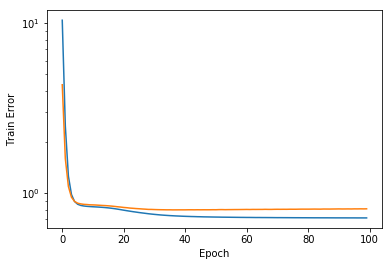

In [17]:
pd.Series(svd_history.history['loss']).plot(logy=True)
pd.Series(svd_history.history['val_loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")

Prediction error

Let's now see how our model does! I'll do a small post-processing step to round off our prediction to the nearest integer. This is usually not done, and thus just a whimsical step, since the training ratings are all integers! There are better ways to encode this intger requirement (one-hot encoding!), but we won't discuss them in this post.

In [21]:
y_svd_hat = model.predict([test.user_id, test.item_id])
y_svd_hat_round = np.round(y_svd_hat, 0)
y_true = test.rating

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print('MAE', mean_absolute_error(y_true, y_svd_hat), mean_absolute_error(y_true, y_svd_hat_round))
print('MSE', mean_squared_error(y_true, y_svd_hat), mean_squared_error(y_true, y_svd_hat_round))

MAE 0.7033630326972429 0.6624775463819265
MSE 0.8068664513854987 0.8889366566354399


Not bad! We're able to get a MAE of 0.66! I'm sure with a bit of parameter/hyper-parameter optimisation, we may be able to improve the results.

**Extracting the learnt embeddings**

We can extract the learnt movie and item embeddings as follows:

In [25]:
item_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(item_embedding_learnt).describe()

,0,1,2
count,3707.000000,3707.000000,3707.000000
mean,1.014400,-1.106096,0.894115
std,0.607391,0.524166,0.556850
min,-1.293583,-4.454706,-1.021973
25%,0.553111,-1.485772,0.490252
50%,1.010024,-1.135719,0.920000
75%,1.456624,-0.781607,1.298432
max,2.987878,1.202077,2.523145


In [26]:
user_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(user_embedding_learnt).describe()

,0,1,2
count,6041.000000,6041.000000,6041.000000
mean,1.026509,-1.007938,1.155853
std,0.483548,0.494692,0.334505
min,-1.755515,-2.725116,-0.783717
25%,0.743386,-1.330060,0.957482
50%,1.067138,-1.007277,1.171492
75%,1.347514,-0.690059,1.368848
max,3.438739,1.627385,2.493719


### Use user embedding cosine similarity to recommend item to user

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

In [51]:
svd_user_cosine_similarity = cosine_similarity(user_embedding_learnt)

In [97]:
import operator
from tqdm import tqdm_notebook, tqdm

In [98]:
top_n = 10
svd_user_top10_sims = []
for user_idx in tqdm(range(len(user_embedding_learnt))):
    sims = {
        sim_user_idx: similarity
        for sim_user_idx, similarity in enumerate(
            svd_user_cosine_similarity[user_idx]) if sim_user_idx != user_idx
    }
    sims = sorted(sims.items(), key=operator.itemgetter(1), reverse=True)
    svd_user_top10_sims.append((user_idx, sims[:top_n]))

100%|██████████| 6041/6041 [00:31<00:00, 162.19it/s]


In [99]:
svd_user_top10_sims[0]

(0,
 [(4612, 0.9999963),
  (5413, 0.99998844),
  (605, 0.99992204),
  (575, 0.9998851),
  (4940, 0.99984634),
  (3935, 0.999827),
  (2615, 0.9998198),
  (2745, 0.9997857),
  (3149, 0.9997063),
  (942, 0.999612)])

In [157]:
def recomendate_by_svd_user_cosine_sims(user_id, top_n=10):
    rec_items = []
    rec_item_ids = set()
    
    rated_item_ids = np.unique(ratings[ratings.user_id == user_id]['item_id'].values)
    sims = svd_user_top10_sims[user_id][1]
    for sim_user_id, sim_score in sims:
        items = ratings[ratings.user_id == sim_user_id]
        items = items.sort_values('rating',ascending=False)[:top_n * 10]
        items = items[['item_id','rating']].to_dict('records')
        
        for rec in items:
            item_id, rating = rec['item_id'], rec['rating']
            if item_id in rec_item_ids or item_id in rated_item_ids: 
                continue
            rec_item_ids.add(item_id)
            rec_items.append((item_id, float(sim_score) * int(rating) / 5))
    return sorted(rec_items, key=operator.itemgetter(1), reverse=True)[:top_n]

In [160]:
recomendate_by_svd_user_cosine_sims(0)

[(573, 0.9999963045120239),
 (3025, 0.9999963045120239),
 (1445, 0.9999963045120239),
 (1466, 0.9999963045120239),
 (21, 0.9999963045120239),
 (699, 0.9999963045120239),
 (1484, 0.9999963045120239),
 (1507, 0.9999963045120239),
 (2403, 0.9999963045120239),
 (1399, 0.9999963045120239)]

In [159]:
recomendate_by_svd_user_cosine_sims(3)

[(3493, 0.9998939633369446),
 (2981, 0.9998939633369446),
 (327, 0.9998939633369446),
 (432, 0.9998939633369446),
 (1104, 0.9998939633369446),
 (2936, 0.9998939633369446),
 (1736, 0.9998939633369446),
 (3134, 0.9998939633369446),
 (3488, 0.9998939633369446),
 (2099, 0.9998939633369446)]

We can see that both the user and the item embeddings have negative elements. There are some applications which require that the learnt embeddings be non-negative. This approach is also called non-negative matrix factorisation, which we'll workout now.

## Non-negative Matrix factorisation (NNMF) in Keras

The code for NNMF remains exactly the same as the code for matrix factorisation. The only change is that we add `non-negativity` constraints on the learnt embeddings. This is done as follows:

In [165]:
from keras.constraints import non_neg
movie_input = keras.layers.Input(shape=[1],name='Item-ID')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors, name='NonNegMovie-Embedding', embeddings_constraint=non_neg())(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)

user_input = keras.layers.Input(shape=[1],name='User-ID')
user_embedding = keras.layers.Embedding(n_users + 1, n_latent_factors,name='NonNegUser-Embedding',embeddings_constraint=non_neg())(user_input)
user_vec = keras.layers.Flatten(name='FlattenUsers')(user_embedding)

prod = keras.layers.merge.dot([movie_vec, user_vec], axes=1, name='DotProduct')
model = keras.Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

We now verify if we are indeed able to learn non-negative embeddings. I'll not compare the performance of NNMF on the test set, in the interest of space.

In [166]:
nnmf_history = model.fit(x=[train.user_id, train.item_id], 
                         y=train.rating,
                         batch_size=128,
                         validation_data=([valid.user_id, valid.item_id], valid.rating),
                         epochs=100, 
                         verbose=1)

Train on 490102 samples, validate on 210044 samples
Epoch 1/100
490102/490102 [==============================] - 7s 15us/step - loss: 8.7242 - val_loss: 3.4287
Epoch 2/100
490102/490102 [==============================] - 7s 15us/step - loss: 2.1229 - val_loss: 1.4592
Epoch 3/100
490102/490102 [==============================] - 7s 15us/step - loss: 1.1842 - val_loss: 1.0540
Epoch 4/100
490102/490102 [==============================] - 10s 20us/step - loss: 0.9569 - val_loss: 0.9317
Epoch 5/100
490102/490102 [==============================] - 9s 19us/step - loss: 0.8841 - val_loss: 0.8879
Epoch 6/100
490102/490102 [==============================] - 7s 15us/step - loss: 0.8570 - val_loss: 0.8708
Epoch 7/100
490102/490102 [==============================] - 8s 16us/step - loss: 0.8455 - val_loss: 0.8625
Epoch 8/100
490102/490102 [==============================] - 9s 18us/step - loss: 0.8399 - val_loss: 0.8588
Epoch 9/100
490102/490102 [==============================] - 8s 15us/step - loss: 0

490102/490102 [==============================] - 5s 10us/step - loss: 0.7214 - val_loss: 0.8002 - los
Epoch 76/100
490102/490102 [==============================] - 5s 9us/step - loss: 0.7209 - val_loss: 0.8007
Epoch 77/100
490102/490102 [==============================] - 7s 14us/step - loss: 0.7206 - val_loss: 0.7994
Epoch 78/100
490102/490102 [==============================] - 7s 15us/step - loss: 0.7199 - val_loss: 0.7999
Epoch 79/100
490102/490102 [==============================] - 6s 13us/step - loss: 0.7197 - val_loss: 0.8003
Epoch 80/100
490102/490102 [==============================] - 6s 13us/step - loss: 0.7195 - val_loss: 0.8003
Epoch 81/100
490102/490102 [==============================] - 7s 15us/step - loss: 0.7190 - val_loss: 0.8000
Epoch 82/100
490102/490102 [==============================] - 7s 15us/step - loss: 0.7188 - val_loss: 0.7995
Epoch 83/100
490102/490102 [==============================] - 7s 15us/step - loss: 0.7184 - val_loss: 0.7996
Epoch 84/100
490102/490102 

In [167]:
movie_embedding_learnt = model.get_layer(name='NonNegMovie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2
count,3707.000000,3707.000000,3707.000000
mean,0.997210,1.037510,0.947827
std,0.599354,0.502234,0.501032
min,-0.000000,-0.000000,-0.000000
25%,0.529559,0.700475,0.594912
50%,1.013889,1.078306,0.960702
75%,1.455629,1.399302,1.296840
max,3.073178,3.101533,3.077158


## Neural networks for recommendation
We'll now create a simple neural network for recommendation, or for estimating rating! This model is very similar to the earlier matrix factorisation models, but differs in the following ways:

Instead of taking a dot product of the user and the item embedding, we concatenate them and use them as features for our neural network. Thus, we are not constrained to the dot product way of combining the embeddings, and can learn complex non-linear relationships.
Due to #1, we can now have a different dimension of user and item embeddings. This can be useful if one dimension is larger than the other.

In [168]:
n_latent_factors_user = 5
n_latent_factors_movie = 8

movie_input = keras.layers.Input(shape=[1],name='Item')
movie_embedding = keras.layers.Embedding(n_movies + 1, n_latent_factors_movie, name='Movie-Embedding')(movie_input)
movie_vec = keras.layers.Flatten(name='FlattenMovies')(movie_embedding)
movie_vec = keras.layers.Dropout(0.2)(movie_vec)


user_input = keras.layers.Input(shape=[1],name='User')
user_vec = keras.layers.Flatten(name='FlattenUsers')(keras.layers.Embedding(n_users + 1, n_latent_factors_user,name='User-Embedding')(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)


concat = keras.layers.merge.concatenate([movie_vec, user_vec], name='Concat')
concat_dropout = keras.layers.Dropout(0.2)(concat)
dense = keras.layers.Dense(200,name='FullyConnected')(concat)
dropout_1 = keras.layers.Dropout(0.2,name='Dropout')(dense)
dense_2 = keras.layers.Dense(100,name='FullyConnected-1')(concat)
dropout_2 = keras.layers.Dropout(0.2,name='Dropout')(dense_2)
dense_3 = keras.layers.Dense(50,name='FullyConnected-2')(dense_2)
dropout_3 = keras.layers.Dropout(0.2,name='Dropout')(dense_3)
dense_4 = keras.layers.Dense(20,name='FullyConnected-3', activation='relu')(dense_3)


result = keras.layers.Dense(1, activation='relu',name='Activation')(dense_4)
adam = Adam(lr=0.005)
model = keras.Model([user_input, movie_input], result)
model.compile(optimizer=adam,loss= 'mean_absolute_error')

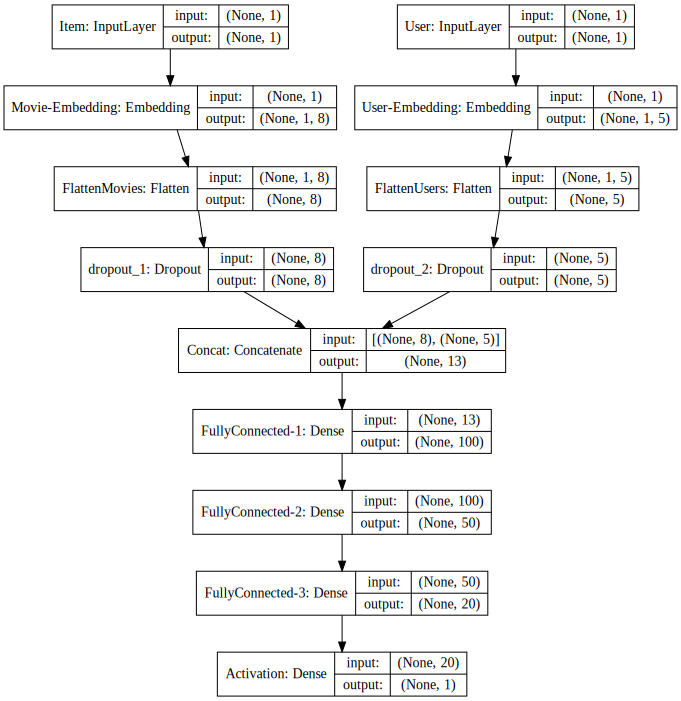

In [169]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))

In [170]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 8)         29656       Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 5)         30205       User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

We can see that the number of parameters is more than what we had in the Matrix Factorisation case. Let's see how this model works. I'll run it for more epochs given that we have more parameters.

In [171]:
dnn_history = model.fit(
    x=[train.user_id, train.item_id],
    y=train.rating,
    batch_size=128,
    validation_data=([valid.user_id, valid.item_id], valid.rating),
    epochs=100,
    verbose=1)

Train on 490102 samples, validate on 210044 samples
Epoch 1/100
490102/490102 [==============================] - 15s 30us/step - loss: 0.7708 - val_loss: 0.7269
Epoch 2/100
490102/490102 [==============================] - 14s 28us/step - loss: 0.7248 - val_loss: 0.7161
Epoch 3/100
490102/490102 [==============================] - 14s 29us/step - loss: 0.7117 - val_loss: 0.7090
Epoch 4/100
490102/490102 [==============================] - 16s 33us/step - loss: 0.7060 - val_loss: 0.7128
Epoch 5/100
490102/490102 [==============================] - 15s 30us/step - loss: 0.7008 - val_loss: 0.7081
Epoch 6/100
490102/490102 [==============================] - 14s 29us/step - loss: 0.6946 - val_loss: 0.6993
Epoch 7/100
490102/490102 [==============================] - 14s 29us/step - loss: 0.6886 - val_loss: 0.6958
Epoch 8/100
490102/490102 [==============================] - 16s 32us/step - loss: 0.6865 - val_loss: 0.6948
Epoch 9/100
490102/490102 [==============================] - 16s 33us/step -

490102/490102 [==============================] - 9s 19us/step - loss: 0.6543 - val_loss: 0.6749
Epoch 76/100
490102/490102 [==============================] - 9s 19us/step - loss: 0.6532 - val_loss: 0.6771
Epoch 77/100
490102/490102 [==============================] - 10s 20us/step - loss: 0.6532 - val_loss: 0.6744
Epoch 78/100
490102/490102 [==============================] - 10s 21us/step - loss: 0.6534 - val_loss: 0.6843
Epoch 79/100
490102/490102 [==============================] - 10s 20us/step - loss: 0.6533 - val_loss: 0.6731
Epoch 80/100
490102/490102 [==============================] - 10s 20us/step - loss: 0.6531 - val_loss: 0.6752
Epoch 81/100
490102/490102 [==============================] - 9s 19us/step - loss: 0.6524 - val_loss: 0.6771
Epoch 82/100
490102/490102 [==============================] - 9s 18us/step - loss: 0.6529 - val_loss: 0.6797
Epoch 83/100
490102/490102 [==============================] - 9s 19us/step - loss: 0.6526 - val_loss: 0.6785
Epoch 84/100
490102/490102 [

In [172]:
y_hat_dnn = np.round(model.predict([test.user_id, test.item_id]), 0)
print(mean_absolute_error(y_true, y_hat_dnn))
print(mean_absolute_error(y_true, model.predict([test.user_id, test.item_id])))

0.6744183721418502
0.682258767114016


In [175]:
movie_embedding_learnt = model.get_layer(name='Movie-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2,3,4,5,6,7
count,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000,3707.000000
mean,-0.732966,0.292757,-0.622670,-0.604828,0.734461,-0.710163,0.585169,-0.685320
std,2.361790,2.550282,2.303044,2.323357,2.374515,2.340138,2.287444,2.325213
min,-9.655300,-9.267989,-9.468780,-10.176050,-6.388413,-9.120623,-7.441594,-8.607080
25%,-2.102432,-1.356239,-1.976128,-1.975513,-0.841068,-2.094217,-0.899721,-2.072798
50%,-0.516368,0.170311,-0.447760,-0.380215,0.537689,-0.466087,0.341874,-0.468090
75%,0.776717,1.843744,0.880186,0.872527,2.167870,0.793298,1.912863,0.857743
max,6.340819,9.432523,6.485994,6.478709,9.059958,6.948986,9.012696,6.071132


In [176]:
movie_embedding_learnt = model.get_layer(name='User-Embedding').get_weights()[0]
pd.DataFrame(movie_embedding_learnt).describe()

,0,1,2,3,4
count,6041.000000,6041.000000,6041.000000,6041.000000,6041.000000
mean,-0.121805,-0.168945,0.026458,-0.109349,0.169009
std,2.316368,2.447150,2.173579,2.289052,2.298896
min,-11.392341,-20.927311,-12.978817,-14.848251,-8.733718
25%,-1.685957,-1.409140,-1.130722,-1.365716,-1.324970
50%,-0.147317,0.007641,-0.076187,0.056088,0.001056
75%,1.391509,1.352277,1.140829,1.370663,1.471107
max,12.148730,10.291594,12.906947,10.998517,12.063497
